In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import lalsimulation as lalsim

from pycbc.filter.matchedfilter import match, optimized_match
from pycbc.types import FrequencySeries

from bilby_lisa.source import lisa_binary_black_hole
from bilby_lisa.source_LW import lisa_binary_black_hole_LW, lisa_binary_black_hole_pseob_LW
from bilby_lisa.source_TD import lisa_binary_black_hole_TD, lisa_binary_black_hole_pseob_TD

from lisatools.sensitivity import get_sensitivity
from bbhx.utils.transform import LISA_to_SSB

import seaborn as sns

sns.set_theme(
    context="notebook",
    style="whitegrid",
    palette="deep",
    font_scale=1.25,
)

/home/lpompili/.conda/envs/pSEOB_LISA/lib/python3.11/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [3]:
Mtot = 1e7
q = 2
m1 = q / (1 + q) * Mtot
m2 = 1 / (1 + q) * Mtot
s1x = 0.0
s1y = 0.0
s1z = 0.2
s2x = 0.0
s2y = 0.0
s2z = 0.1
phiRef = 0.0
distance = 50 * 1e3
inclination = np.pi / 3

f_max = 1e-2 / (Mtot/2e7)
f_ref = 1e-4 / (Mtot/2e7)
f_min = 1e-4 / (Mtot/2e7)
deltaF = 1/2628000.0 # 1 month duration

frequency_array = np.arange(f_min, f_max, deltaF)

ra = np.pi / 3
dec = np.pi / 3
psi = np.pi / 3

geocent_time = 0.0

In [4]:
dict_bbhx = lisa_binary_black_hole(
    frequency_array, m1, m2, distance, s1z, s2z,
    inclination, phiRef, ra, dec, psi, geocent_time,
    reference_frequency=f_ref, minimum_frequency=f_min
)

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


In [5]:
(theta_jn, phi_jl, tilt_1, tilt_2, phi_12, a_1, a_2) = (
    lalsim.SimInspiralTransformPrecessingWvf2PE(
        inclination, s1x, s1y, s1z, s2x, s2y, s2z, m1, m2, f_ref, phiRef
    )
)

In [6]:
dict_lw = lisa_binary_black_hole_LW(frequency_array, m1, m2, distance, 
                                       a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef, 
                                       ra, dec, psi, geocent_time, waveform_approximant = "IMRPhenomD", 
                                       reference_frequency=f_ref, minimum_frequency=f_min,
                                       # mode_array=[(2,2)]
                                       )

/home/lpompili/.conda/envs/pSEOB_LISA/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


In [7]:
geocent_time_ssb, ra_ssb, dec_ssb, psi_ssb = LISA_to_SSB(0.0, np.pi/3, np.pi/3, np.pi/3)

In [8]:
geocent_time_ssb, ra_ssb, dec_ssb, psi_ssb

(-311.88469873224625,
 2.5356327271216195,
 0.7069211022664601,
 2.7830844194777407)

In [9]:
dict_td = lisa_binary_black_hole_TD(frequency_array, m1, m2, distance, 
                                       a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef, 
                                       ra_ssb, dec_ssb, psi_ssb, geocent_time_ssb, waveform_approximant = "IMRPhenomD", 
                                       reference_frequency=f_ref, minimum_frequency=f_min,
                                       # mode_array=[(2,2)]
                                       )

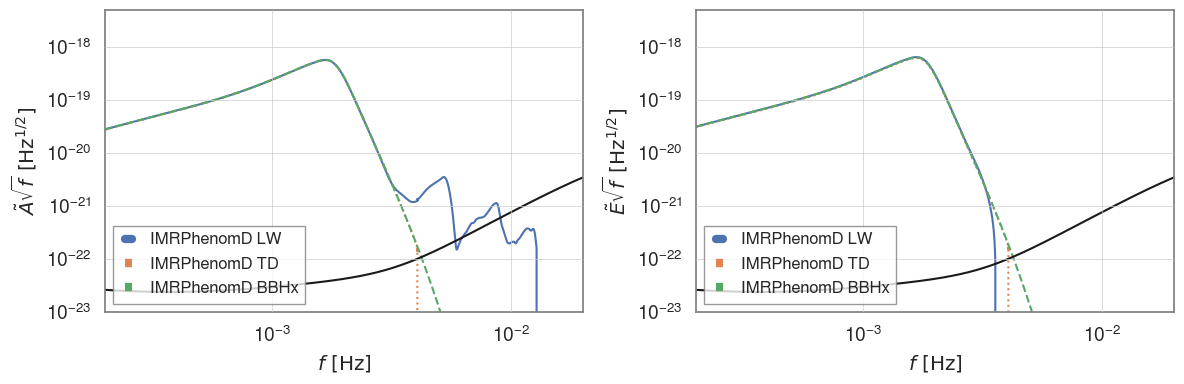

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,4))

ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_lw["LISA_A"]), label = "IMRPhenomD LW")
ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_td["LISA_A"]), label = "IMRPhenomD TD", ls = ':')
ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_bbhx["LISA_A"]), label = "IMRPhenomD BBHx", ls = '--')

ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_lw["LISA_E"]), label = "IMRPhenomD LW")
ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_td["LISA_E"]), label = "IMRPhenomD TD", ls = ':')
ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_bbhx["LISA_E"]), label = "IMRPhenomD BBHx", ls = '--')

fn = np.logspace(-5, -1, 10000)

Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
ax1.loglog(fn, Sn_char_strain, c="k")

Sn_char_strain = get_sensitivity(fn, sens_fn="E1TDISens", return_type="char_strain")
ax2.loglog(fn, Sn_char_strain, c="k")

for ax in (ax1,ax2):
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(1e-23, 5e-18)
    ax.set_xlabel(r"$f~[\rm{Hz}]$")
    ax.legend(loc=3, fontsize=12)

ax1.set_ylabel(r"$\tilde{A}\sqrt{f}~[\rm{Hz}^{1/2}]$")
ax2.set_ylabel(r"$\tilde{E}\sqrt{f}~[\rm{Hz}^{1/2}]$")

plt.tight_layout()


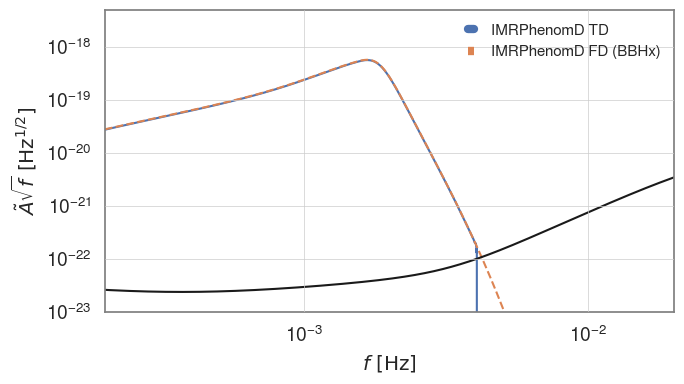

In [11]:
fig, (ax1) = plt.subplots(ncols=1, figsize = (7,4))

ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_td["LISA_A"]), label = "IMRPhenomD TD")
ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_bbhx["LISA_A"]), label = "IMRPhenomD FD (BBHx)", ls = '--')

fn = np.logspace(-5, -1, 10000)

Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
ax1.loglog(fn, Sn_char_strain, c="k")

Sn_char_strain = get_sensitivity(fn, sens_fn="E1TDISens", return_type="char_strain")
ax2.loglog(fn, Sn_char_strain, c="k")

for ax in (ax1,ax2):
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(1e-23, 5e-18)
    ax.set_xlabel(r"$f~[\rm{Hz}]$")
    ax.legend(loc=1, fontsize=11, frameon=False)

ax1.set_ylabel(r"$\tilde{A}\sqrt{f}~[\rm{Hz}^{1/2}]$")
ax2.set_ylabel(r"$\tilde{E}\sqrt{f}~[\rm{Hz}^{1/2}]$")

plt.tight_layout()

plt.savefig("response_1.png", bbox_inches="tight", dpi=200)

In [12]:
from lisatools.sensitivity import SensitivityMatrix, A1TDISens, E1TDISens 
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.datacontainer import DataResidualArray

In [13]:
data = DataResidualArray([dict_lw["LISA_A"], dict_lw["LISA_E"]], f_arr=frequency_array)

In [14]:
sens_mat = SensitivityMatrix(data.f_arr, [A1TDISens, E1TDISens])

In [15]:
analysis = AnalysisContainer(data, sens_mat)

In [16]:
analysis.snr()

1244.6969614304858

In [17]:
psd = get_sensitivity(frequency_array, sens_fn="A1TDISens", return_type="PSD")
print(
    1- match(
        FrequencySeries(dict_bbhx["LISA_A"], deltaF),
        FrequencySeries(dict_lw["LISA_A"], deltaF),
        psd=FrequencySeries(psd, deltaF),
        subsample_interpolation=True,
    )[0]
)

5.468236452199626e-06


In [18]:
psd = get_sensitivity(frequency_array, sens_fn="A1TDISens", return_type="PSD")
print(
    1- match(
        FrequencySeries(dict_td["LISA_A"], deltaF),
        FrequencySeries(dict_lw["LISA_A"], deltaF),
        psd=FrequencySeries(psd, deltaF),
        subsample_interpolation=True,
    )[0]
)

4.477487655862866e-06


In [19]:
psd = get_sensitivity(frequency_array, sens_fn="A1TDISens", return_type="PSD")
print(
    1- match(
        FrequencySeries(dict_td["LISA_A"], deltaF),
        FrequencySeries(dict_bbhx["LISA_A"], deltaF),
        psd=FrequencySeries(psd, deltaF),
        subsample_interpolation=True,
    )[0]
)

5.003970128258928e-07


In [20]:
psd = get_sensitivity(frequency_array, sens_fn="A1TDISens", return_type="PSD")
print(
    1- optimized_match(
        FrequencySeries(dict_td["LISA_A"], deltaF),
        FrequencySeries(dict_bbhx["LISA_A"], deltaF),
        psd=FrequencySeries(psd, deltaF),
    )[0]
)

lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
2.949689733577898e-07


In [21]:
dict_seob = lisa_binary_black_hole_TD(frequency_array, m1, m2, distance, 
                                       a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef, 
                                       ra_ssb, dec_ssb, psi_ssb, geocent_time_ssb, 
                                       waveform_approximant = "SEOBNRv5PHM", 
                                       reference_frequency=f_ref, minimum_frequency=f_min,
                                       # mode_array=[(2,2)]
                                       )

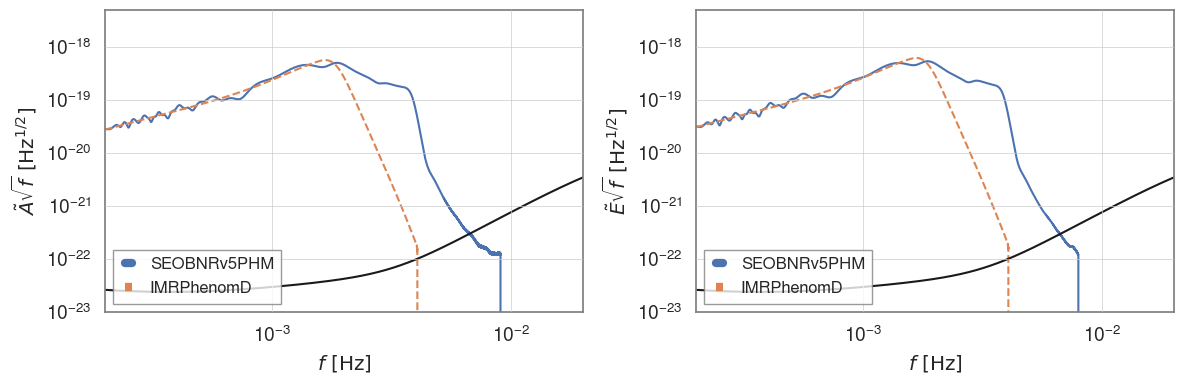

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,4))

ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_A"]), label = "SEOBNRv5PHM")
ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_td["LISA_A"]), label = "IMRPhenomD", ls = '--')

ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_E"]), label = "SEOBNRv5PHM")
ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_td["LISA_E"]), label = "IMRPhenomD", ls = '--')

fn = np.logspace(-5, -1, 10000)

Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
ax1.loglog(fn, Sn_char_strain, c="k")

Sn_char_strain = get_sensitivity(fn, sens_fn="E1TDISens", return_type="char_strain")
ax2.loglog(fn, Sn_char_strain, c="k")

for ax in (ax1,ax2):
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(1e-23, 5e-18)
    ax.set_xlabel(r"$f~[\rm{Hz}]$")
    ax.legend(loc=3, fontsize=12)

ax1.set_ylabel(r"$\tilde{A}\sqrt{f}~[\rm{Hz}^{1/2}]$")
ax2.set_ylabel(r"$\tilde{E}\sqrt{f}~[\rm{Hz}^{1/2}]$")

plt.tight_layout()


In [23]:
domega220 = 0.1
dtau220 = 0.1

domega330 = 0.1
dtau330 = 0.1
domega210 = 0.1
dtau210 = 0.1
domega440 = 0.1
dtau440 = 0.1
domega550 = 0.1
dtau550 = 0.1
domega320 = 0.1
dtau320 = 0.1
domega430 = 0.1
dtau430 = 0.1
dA22 = 0
dw22 = 0
dA33 = 0
dw33 = 0
dA21 = 0
dw21 = 0
dA44 = 0
dw44 = 0
dA55 = 0
dw55 = 0
dA32 = 0
dw32 = 0
dA43 = 0
dw43 = 0
dTpeak = 0
da6 = 0
ddSO = 0

In [24]:
dict_pseob = lisa_binary_black_hole_pseob_TD(frequency_array, m1, m2, distance, 
                                       a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef, 
                                       ra_ssb, dec_ssb, psi_ssb, geocent_time_ssb, 
                                       domega220, dtau220, domega330, dtau330, domega210, dtau210, 
                                       domega440, dtau440, domega550, dtau550, domega320, dtau320, 
                                       domega430, dtau430, dA22, dw22, dA33, dw33, dA21, dw21, dA44, 
                                       dw44, dA55, dw55, dA32, dw32, dA43, dw43, dTpeak, da6, ddSO,
                                       waveform_approximant = "SEOBNRv5PHM", 
                                       reference_frequency=f_ref, minimum_frequency=f_min,
                                       # mode_array=[(2,2)]
                                       )

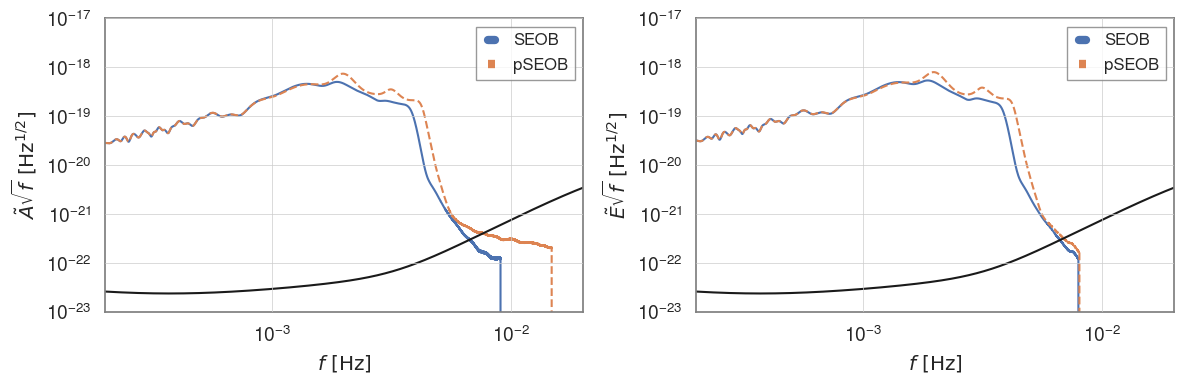

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,4))

ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_A"]), label = "SEOB")
ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_pseob["LISA_A"]), label = "pSEOB", ls = '--')

ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_E"]), label = "SEOB")
ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_pseob["LISA_E"]), label = "pSEOB", ls = '--')

fn = np.logspace(-5, -1, 10000)

Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
ax1.loglog(fn, Sn_char_strain, c="k")

Sn_char_strain = get_sensitivity(fn, sens_fn="E1TDISens", return_type="char_strain")
ax2.loglog(fn, Sn_char_strain, c="k")

for ax in (ax1,ax2):
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(1e-23, 1e-17)
    ax.set_xlabel(r"$f~[\rm{Hz}]$")
    ax.legend(loc=1, fontsize=12)

ax1.set_ylabel(r"$\tilde{A}\sqrt{f}~[\rm{Hz}^{1/2}]$")
ax2.set_ylabel(r"$\tilde{E}\sqrt{f}~[\rm{Hz}^{1/2}]$")

plt.tight_layout()


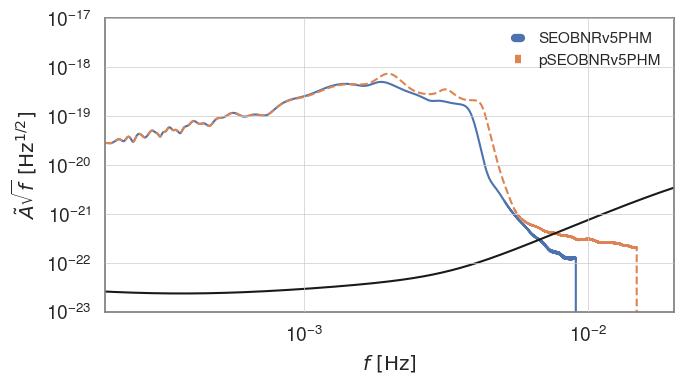

In [26]:
fig, (ax1) = plt.subplots(ncols=1, figsize = (7,4))

ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_A"]), label = "SEOBNRv5PHM")
ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_pseob["LISA_A"]), label = "pSEOBNRv5PHM", ls = '--')

fn = np.logspace(-5, -1, 10000)

Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
ax1.loglog(fn, Sn_char_strain, c="k")

for ax in [ax1]:
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(1e-23, 1e-17)
    ax.set_xlabel(r"$f~[\rm{Hz}]$")
    ax.legend(loc=1, fontsize=11, frameon=False)

ax1.set_ylabel(r"$\tilde{A}\sqrt{f}~[\rm{Hz}^{1/2}]$")

plt.tight_layout()
plt.savefig("response_2.png", bbox_inches="tight", dpi=200)

In [27]:
from lisatools.sensitivity import SensitivityMatrix, A1TDISens, E1TDISens 
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.datacontainer import DataResidualArray

In [28]:
data = DataResidualArray([dict_pseob["LISA_A"], dict_pseob["LISA_E"]], f_arr=frequency_array)

In [29]:
sens_mat = SensitivityMatrix(data.f_arr, [A1TDISens, E1TDISens])

In [30]:
analysis = AnalysisContainer(data, sens_mat)

In [31]:
analysis.snr()

1556.8705294448212

In [32]:
template = DataResidualArray([dict_seob["LISA_A"], dict_seob["LISA_E"]], f_arr=frequency_array)

In [33]:
analysis.template_snr(template)

(1320.4531230237053, 1377.4021318071652)